# Optimization of TLN using differentiable simulation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from typing import Dict

In [3]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import tln_spec, mm_tln_spec, pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True))
[0.         0.02002002 0.04004004 0.06006006 0.08008008 0.1001001
 0.12012012 0.14014014 0.16016016 0.18018018 0.2002002  0.22022022
 0.24024024 0.26026026 0.28028028 0.3003003  0.32032032 0.34034034
 0.36036036 0.38038038 0.4004004  0.42042042 0.44044044 0.46046046
 0.48048048 0.5005005  0.52052052 0.54054054 0.56056056 0.58058058
 0.6006006  0.62062062 0.64064064 0.66066066 0.68068068 0.7007007
 0.72072072 0.74074074 0.76076076 0.78078078 0.8008008  0.82082082
 0.84084084 0.86086086 0.88088088 0.9009009  0.92092092 0.94094094
 0.96096096 0.98098098 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.  

## Generate a TLN graph from specification

--- block colors ---
--- line colors ---


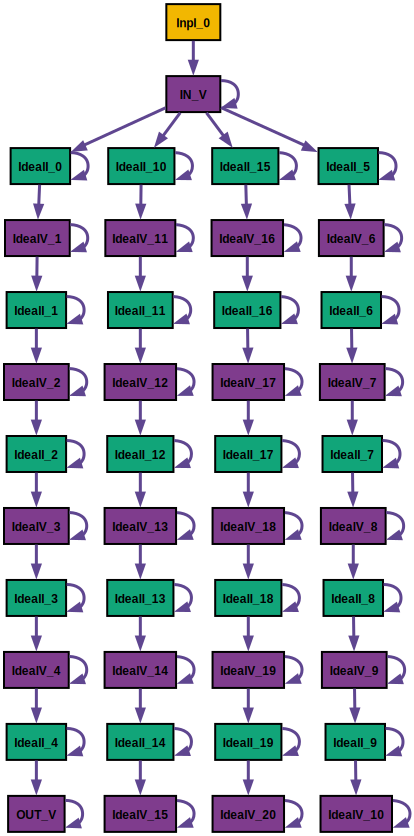

In [71]:
branch_args = {
    "line_len": 5,
    "branch_stride": 5,
    "branches_per_node": 3,
    "branch_len": 4,
    "branch_offset": 0,
}
itl_small_graph, _, _ = create_tline_branch(
    IdealV, IdealI, lambda: IdealE(), **branch_args
)
itl_small_graph
from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=tln_spec, cdg=itl_small_graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [57]:
compiler = ArkCompiler(rewrite=SympyRewriteGen())
sympy_pairs = compiler.compile_sympy(cdg=itl_small_graph, cdg_spec=tln_spec, help_fn=[])

Compiling order 1 nodes: 100%|██████████| 41/41 [00:00<00:00, 1661.74it/s]


In [58]:
sympy_pairs

[(ddt_IN_V,
  -IN_V*IN_V_g/IN_V_c - IdealI_0/IN_V_c - IdealI_10/IN_V_c - IdealI_15/IN_V_c - IdealI_5/IN_V_c + (-IN_V*InpI_0_g + InpI_0_fn(time))/IN_V_c),
 (ddt_IdealI_0,
  IN_V/IdealI_0_l - IdealI_0*IdealI_0_r/IdealI_0_l - IdealV_1/IdealI_0_l),
 (ddt_IdealI_1,
  -IdealI_1*IdealI_1_r/IdealI_1_l + IdealV_1/IdealI_1_l - IdealV_2/IdealI_1_l),
 (ddt_IdealI_10,
  IN_V/IdealI_10_l - IdealI_10*IdealI_10_r/IdealI_10_l - IdealV_11/IdealI_10_l),
 (ddt_IdealI_11,
  -IdealI_11*IdealI_11_r/IdealI_11_l + IdealV_11/IdealI_11_l - IdealV_12/IdealI_11_l),
 (ddt_IdealI_12,
  -IdealI_12*IdealI_12_r/IdealI_12_l + IdealV_12/IdealI_12_l - IdealV_13/IdealI_12_l),
 (ddt_IdealI_13,
  -IdealI_13*IdealI_13_r/IdealI_13_l + IdealV_13/IdealI_13_l - IdealV_14/IdealI_13_l),
 (ddt_IdealI_14,
  -IdealI_14*IdealI_14_r/IdealI_14_l + IdealV_14/IdealI_14_l - IdealV_15/IdealI_14_l),
 (ddt_IdealI_15,
  IN_V/IdealI_15_l - IdealI_15*IdealI_15_r/IdealI_15_l - IdealV_16/IdealI_15_l),
 (ddt_IdealI_16,
  -IdealI_16*IdealI_16_r/Ideal

We can now convert these into a set of differential equations, using some amount of parsing.

In [59]:
def collapse_derivative(pair: tuple[sp.Symbol, sp.Expr]) -> sp.Eq:
    """Turns tuple of derivative + sympy expression into a single sympy equation."""
    if (var_name := pair[0].name).startswith('ddt_'):
        symbol = sp.symbols(var_name[4:])
        equation = sp.Eq(sp.Derivative(symbol, sp.symbols('time')), pair[1])
        return equation.subs(sp.symbols('time'), sp.symbols('t'))
    else:
        raise ValueError("Not a derivative expression.")
sympy_eqs = [collapse_derivative(pair) for pair in sympy_pairs]
sympy_eqs

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - IdealI_0/IN_V_c - IdealI_10/IN_V_c - IdealI_15/IN_V_c - IdealI_5/IN_V_c + (-IN_V*InpI_0_g + InpI_0_fn(t))/IN_V_c),
 Eq(Derivative(IdealI_0, t), IN_V/IdealI_0_l - IdealI_0*IdealI_0_r/IdealI_0_l - IdealV_1/IdealI_0_l),
 Eq(Derivative(IdealI_1, t), -IdealI_1*IdealI_1_r/IdealI_1_l + IdealV_1/IdealI_1_l - IdealV_2/IdealI_1_l),
 Eq(Derivative(IdealI_10, t), IN_V/IdealI_10_l - IdealI_10*IdealI_10_r/IdealI_10_l - IdealV_11/IdealI_10_l),
 Eq(Derivative(IdealI_11, t), -IdealI_11*IdealI_11_r/IdealI_11_l + IdealV_11/IdealI_11_l - IdealV_12/IdealI_11_l),
 Eq(Derivative(IdealI_12, t), -IdealI_12*IdealI_12_r/IdealI_12_l + IdealV_12/IdealI_12_l - IdealV_13/IdealI_12_l),
 Eq(Derivative(IdealI_13, t), -IdealI_13*IdealI_13_r/IdealI_13_l + IdealV_13/IdealI_13_l - IdealV_14/IdealI_13_l),
 Eq(Derivative(IdealI_14, t), -IdealI_14*IdealI_14_r/IdealI_14_l + IdealV_14/IdealI_14_l - IdealV_15/IdealI_14_l),
 Eq(Derivative(IdealI_15, t), IN_V/IdealI_15_l - IdealI_15*I

Now we need to substitute the forcing function `InpI_0_fn` into a pulse function (a piecewise function defined in SymPy).

In [60]:
t = sp.symbols('t')
InpI_0_fn = sp.Function('InpI_0_fn')
replaced_function = sympy_eqs[0].subs(InpI_0_fn(t), pulse_sympy(t))
replaced_function

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - IdealI_0/IN_V_c - IdealI_10/IN_V_c - IdealI_15/IN_V_c - IdealI_5/IN_V_c + (-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

In [61]:
sympy_eqs_expanded = [replaced_function if i == 0 else f for i, f in enumerate(sympy_eqs)]

In [62]:
sympy_eqs_expanded

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - IdealI_0/IN_V_c - IdealI_10/IN_V_c - IdealI_15/IN_V_c - IdealI_5/IN_V_c + (-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(IdealI_0, t), IN_V/IdealI_0_l - IdealI_0*IdealI_0_r/IdealI_0_l - IdealV_1/IdealI_0_l),
 Eq(Derivative(IdealI_1, t), -IdealI_1*IdealI_1_r/IdealI_1_l + IdealV_1/IdealI_1_l - IdealV_2/IdealI_1_l),
 Eq(Derivative(IdealI_10, t), IN_V/IdealI_10_l - IdealI_10*IdealI_10_r/IdealI_10_l - IdealV_11/IdealI_10_l),
 Eq(Derivative(IdealI_11, t), -IdealI_11*IdealI_11_r/IdealI_11_l + IdealV_11/IdealI_11_l - IdealV_12/IdealI_11_l),
 Eq(Derivative(IdealI_12, t), -IdealI_12*IdealI_12_r/IdealI_12_l + IdealV_12/IdealI_12_l - IdealV_13/IdealI_12_l),
 Eq(Derivative(IdealI_13, t), -IdealI_13*IdealI_13_r/IdealI_13_l + IdealV_13/IdealI_13_l - IdealV_14/IdealI_13_l),
 Eq(Derivative(IdealI_14, t), -IdealI_14*Ide

In [63]:
# Find all the LHS variables in the set of equations
lhs_vars = [list(eq.lhs.free_symbols)[0] for eq in sympy_eqs_expanded]
lhs_vars

[IN_V,
 IdealI_0,
 IdealI_1,
 IdealI_10,
 IdealI_11,
 IdealI_12,
 IdealI_13,
 IdealI_14,
 IdealI_15,
 IdealI_16,
 IdealI_17,
 IdealI_18,
 IdealI_19,
 IdealI_2,
 IdealI_3,
 IdealI_4,
 IdealI_5,
 IdealI_6,
 IdealI_7,
 IdealI_8,
 IdealI_9,
 IdealV_1,
 IdealV_10,
 IdealV_11,
 IdealV_12,
 IdealV_13,
 IdealV_14,
 IdealV_15,
 IdealV_16,
 IdealV_17,
 IdealV_18,
 IdealV_19,
 IdealV_2,
 IdealV_20,
 IdealV_3,
 IdealV_4,
 IdealV_6,
 IdealV_7,
 IdealV_8,
 IdealV_9,
 OUT_V]

In [64]:
# Figure out which parameters are necessary to evaluate the equations
param_vars = [eq.free_symbols - set(lhs_vars) for eq in sympy_eqs_expanded]
all_param_vars = set().union(*param_vars)
all_param_vars.remove(sp.symbols('t'))
del param_vars
%pprint
display(all_param_vars)
%pprint

Pretty printing has been turned OFF


{IdealI_9_l, IdealI_7_r, IdealI_3_r, IdealI_15_l, IdealV_14_g, IdealI_0_l, OUT_V_c, IdealI_5_l, IdealV_1_c, IdealV_16_c, IdealI_17_l, IdealI_1_l, IdealI_16_r, IdealV_1_g, IdealV_10_c, IdealV_19_c, IdealV_2_c, IdealV_2_g, IdealV_13_g, IdealI_11_l, IdealV_11_c, IdealI_14_r, IdealI_10_r, IdealV_10_g, IdealV_4_c, IdealI_6_r, IdealI_13_l, IdealV_20_c, IdealV_15_g, IdealI_10_l, IdealV_12_c, IdealV_9_g, IdealI_18_l, IdealI_4_r, IdealV_17_c, IdealV_8_c, IdealV_9_c, IdealV_17_g, IdealI_15_r, IdealV_11_g, IdealV_7_g, IdealV_16_g, IdealV_13_c, IdealI_8_l, IdealI_2_l, IdealI_11_r, IdealI_1_r, IdealV_19_g, IdealI_9_r, IdealV_20_g, IdealV_6_g, IdealI_12_l, IdealI_14_l, IdealV_12_g, IdealV_14_c, IdealV_6_c, IdealI_4_l, IdealI_6_l, IdealI_18_r, IdealV_18_g, IdealI_0_r, IdealI_5_r, IdealI_12_r, IdealV_15_c, IdealI_8_r, IdealV_3_c, IdealI_2_r, IdealI_19_l, IdealI_3_l, InpI_0_g, IN_V_c, IdealV_4_g, IdealV_7_c, OUT_V_g, IdealV_18_c, IdealI_7_l, IdealI_19_r, IdealV_8_g, IdealI_16_l, IdealI_13_r, IdealV_3_g

Pretty printing has been turned ON


In [65]:
# Now we gather the parameters necessary from the respective nodes in the graph
def get_param_from_dict(param_name: str) -> float:
    node_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return node_param_dict[node_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in itl_small_graph.nodes}

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict

{IdealI_9_l: 1e-09,
 IdealI_7_r: 0.0,
 IdealI_3_r: 0.0,
 IdealI_15_l: 1e-09,
 IdealV_14_g: 0.0,
 IdealI_0_l: 1e-09,
 OUT_V_c: 1e-09,
 IdealI_5_l: 1e-09,
 IdealV_1_c: 1e-09,
 IdealV_16_c: 1e-09,
 IdealI_17_l: 1e-09,
 IdealI_1_l: 1e-09,
 IdealI_16_r: 0.0,
 IdealV_1_g: 0.0,
 IdealV_10_c: 1e-09,
 IdealV_19_c: 1e-09,
 IdealV_2_c: 1e-09,
 IdealV_2_g: 0.0,
 IdealV_13_g: 0.0,
 IdealI_11_l: 1e-09,
 IdealV_11_c: 1e-09,
 IdealI_14_r: 0.0,
 IdealI_10_r: 0.0,
 IdealV_10_g: 0.0,
 IdealV_4_c: 1e-09,
 IdealI_6_r: 0.0,
 IdealI_13_l: 1e-09,
 IdealV_20_c: 1e-09,
 IdealV_15_g: 0.0,
 IdealI_10_l: 1e-09,
 IdealV_12_c: 1e-09,
 IdealV_9_g: 0.0,
 IdealI_18_l: 1e-09,
 IdealI_4_r: 0.0,
 IdealV_17_c: 1e-09,
 IdealV_8_c: 1e-09,
 IdealV_9_c: 1e-09,
 IdealV_17_g: 0.0,
 IdealI_15_r: 0.0,
 IdealV_11_g: 0.0,
 IdealV_7_g: 0.0,
 IdealV_16_g: 0.0,
 IdealV_13_c: 1e-09,
 IdealI_8_l: 1e-09,
 IdealI_2_l: 1e-09,
 IdealI_11_r: 0.0,
 IdealI_1_r: 0.0,
 IdealV_19_g: 0.0,
 IdealI_9_r: 0.0,
 IdealV_20_g: 0.0,
 IdealV_6_g: 0.0,
 Idea

In [66]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
lhs_init_dict = {k: 0.0 for k in lhs_vars}

### Reminder of relevant variables

In [67]:
display(sympy_eqs_expanded)  # List of all equations defining the system
display(lhs_vars)  # Names of all left-hand side variables
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - IdealI_0/IN_V_c - IdealI_10/IN_V_c - IdealI_15/IN_V_c - IdealI_5/IN_V_c + (-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(IdealI_0, t), IN_V/IdealI_0_l - IdealI_0*IdealI_0_r/IdealI_0_l - IdealV_1/IdealI_0_l),
 Eq(Derivative(IdealI_1, t), -IdealI_1*IdealI_1_r/IdealI_1_l + IdealV_1/IdealI_1_l - IdealV_2/IdealI_1_l),
 Eq(Derivative(IdealI_10, t), IN_V/IdealI_10_l - IdealI_10*IdealI_10_r/IdealI_10_l - IdealV_11/IdealI_10_l),
 Eq(Derivative(IdealI_11, t), -IdealI_11*IdealI_11_r/IdealI_11_l + IdealV_11/IdealI_11_l - IdealV_12/IdealI_11_l),
 Eq(Derivative(IdealI_12, t), -IdealI_12*IdealI_12_r/IdealI_12_l + IdealV_12/IdealI_12_l - IdealV_13/IdealI_12_l),
 Eq(Derivative(IdealI_13, t), -IdealI_13*IdealI_13_r/IdealI_13_l + IdealV_13/IdealI_13_l - IdealV_14/IdealI_13_l),
 Eq(Derivative(IdealI_14, t), -IdealI_14*Ide

[IN_V,
 IdealI_0,
 IdealI_1,
 IdealI_10,
 IdealI_11,
 IdealI_12,
 IdealI_13,
 IdealI_14,
 IdealI_15,
 IdealI_16,
 IdealI_17,
 IdealI_18,
 IdealI_19,
 IdealI_2,
 IdealI_3,
 IdealI_4,
 IdealI_5,
 IdealI_6,
 IdealI_7,
 IdealI_8,
 IdealI_9,
 IdealV_1,
 IdealV_10,
 IdealV_11,
 IdealV_12,
 IdealV_13,
 IdealV_14,
 IdealV_15,
 IdealV_16,
 IdealV_17,
 IdealV_18,
 IdealV_19,
 IdealV_2,
 IdealV_20,
 IdealV_3,
 IdealV_4,
 IdealV_6,
 IdealV_7,
 IdealV_8,
 IdealV_9,
 OUT_V]

{IdealI_9_l: 1e-09,
 IdealI_7_r: 0.0,
 IdealI_3_r: 0.0,
 IdealI_15_l: 1e-09,
 IdealV_14_g: 0.0,
 IdealI_0_l: 1e-09,
 OUT_V_c: 1e-09,
 IdealI_5_l: 1e-09,
 IdealV_1_c: 1e-09,
 IdealV_16_c: 1e-09,
 IdealI_17_l: 1e-09,
 IdealI_1_l: 1e-09,
 IdealI_16_r: 0.0,
 IdealV_1_g: 0.0,
 IdealV_10_c: 1e-09,
 IdealV_19_c: 1e-09,
 IdealV_2_c: 1e-09,
 IdealV_2_g: 0.0,
 IdealV_13_g: 0.0,
 IdealI_11_l: 1e-09,
 IdealV_11_c: 1e-09,
 IdealI_14_r: 0.0,
 IdealI_10_r: 0.0,
 IdealV_10_g: 0.0,
 IdealV_4_c: 1e-09,
 IdealI_6_r: 0.0,
 IdealI_13_l: 1e-09,
 IdealV_20_c: 1e-09,
 IdealV_15_g: 0.0,
 IdealI_10_l: 1e-09,
 IdealV_12_c: 1e-09,
 IdealV_9_g: 0.0,
 IdealI_18_l: 1e-09,
 IdealI_4_r: 0.0,
 IdealV_17_c: 1e-09,
 IdealV_8_c: 1e-09,
 IdealV_9_c: 1e-09,
 IdealV_17_g: 0.0,
 IdealI_15_r: 0.0,
 IdealV_11_g: 0.0,
 IdealV_7_g: 0.0,
 IdealV_16_g: 0.0,
 IdealV_13_c: 1e-09,
 IdealI_8_l: 1e-09,
 IdealI_2_l: 1e-09,
 IdealI_11_r: 0.0,
 IdealI_1_r: 0.0,
 IdealV_19_g: 0.0,
 IdealI_9_r: 0.0,
 IdealV_20_g: 0.0,
 IdealV_6_g: 0.0,
 Idea

## Defining the DiffEQ solve function


In [68]:
def keys_to_str(d: dict) -> dict:
    return {str(k): v for k, v in d.items()}
keys_to_str(lhs_init_dict)

{'IN_V': 0.0,
 'IdealI_0': 0.0,
 'IdealI_1': 0.0,
 'IdealI_10': 0.0,
 'IdealI_11': 0.0,
 'IdealI_12': 0.0,
 'IdealI_13': 0.0,
 'IdealI_14': 0.0,
 'IdealI_15': 0.0,
 'IdealI_16': 0.0,
 'IdealI_17': 0.0,
 'IdealI_18': 0.0,
 'IdealI_19': 0.0,
 'IdealI_2': 0.0,
 'IdealI_3': 0.0,
 'IdealI_4': 0.0,
 'IdealI_5': 0.0,
 'IdealI_6': 0.0,
 'IdealI_7': 0.0,
 'IdealI_8': 0.0,
 'IdealI_9': 0.0,
 'IdealV_1': 0.0,
 'IdealV_10': 0.0,
 'IdealV_11': 0.0,
 'IdealV_12': 0.0,
 'IdealV_13': 0.0,
 'IdealV_14': 0.0,
 'IdealV_15': 0.0,
 'IdealV_16': 0.0,
 'IdealV_17': 0.0,
 'IdealV_18': 0.0,
 'IdealV_19': 0.0,
 'IdealV_2': 0.0,
 'IdealV_20': 0.0,
 'IdealV_3': 0.0,
 'IdealV_4': 0.0,
 'IdealV_6': 0.0,
 'IdealV_7': 0.0,
 'IdealV_8': 0.0,
 'IdealV_9': 0.0,
 'OUT_V': 0.0}

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1000000],
  ys=f64[1000000,41],
  interpolation=None,
  stats={
    'max_steps':
    1000000,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

{'max_steps': 1000000,
 'num_accepted_steps': Array(749000, dtype=int64, weak_type=True),
 'num_rejected_steps': Array(0, dtype=int64, weak_type=True),
 'num_steps': Array(749000, dtype=int64, weak_type=True)}

Finished getting solution!


/opt/homebrew/Caskroom/miniforge/base/envs/ark/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


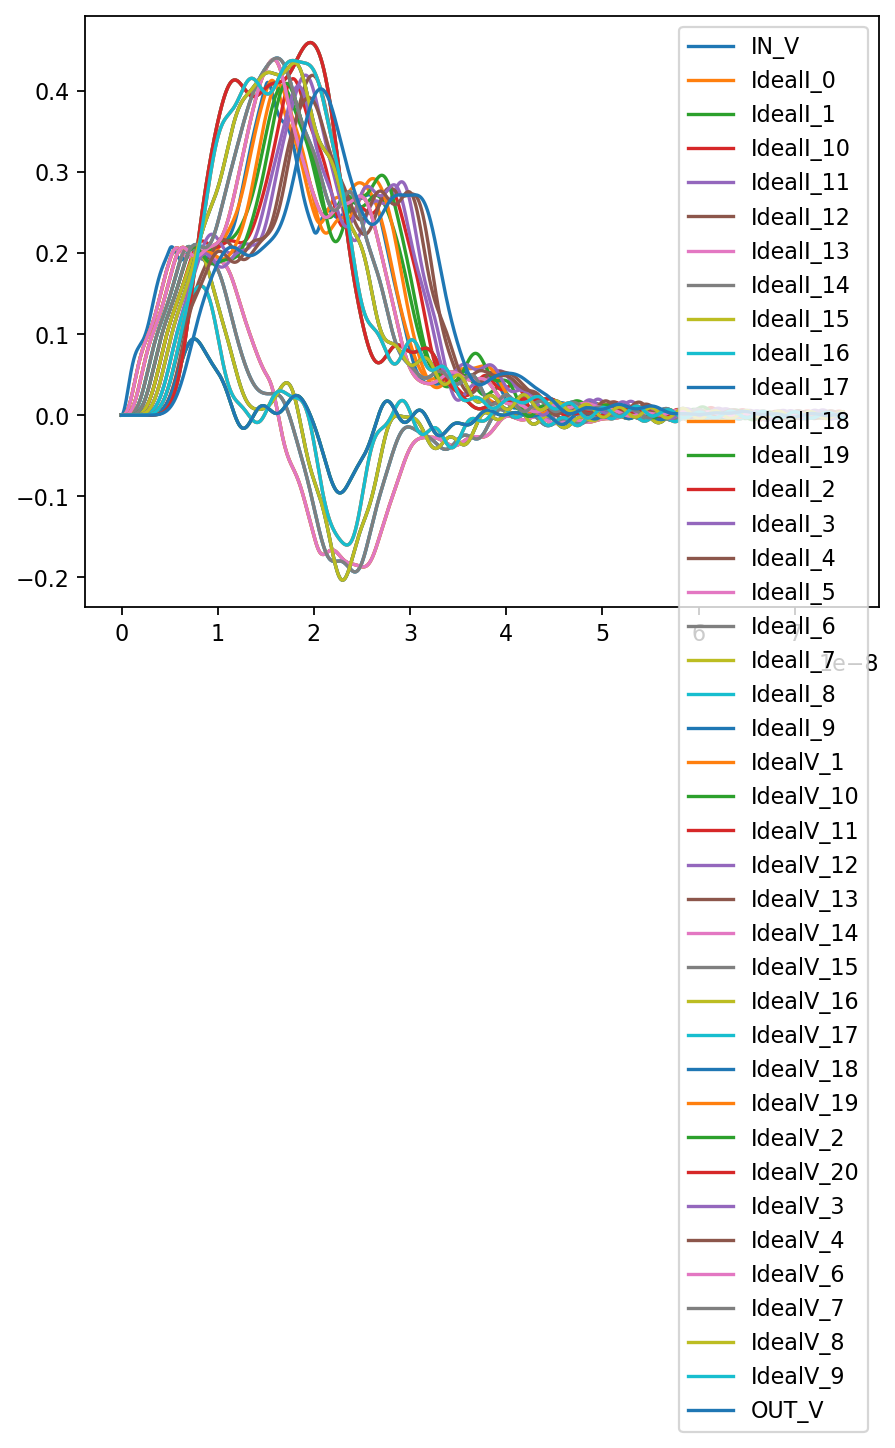

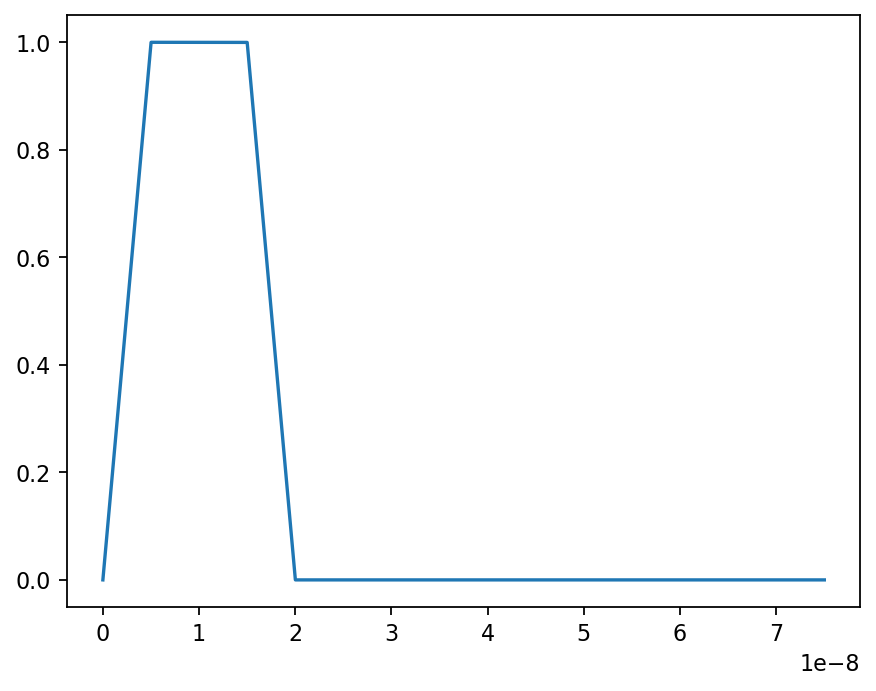

In [69]:
%matplotlib inline
def lambdify_evaluate(expr: sp.Expr, vec_values: dict, parameter_values: dict) -> jax.Array:
    """Lambdifies a sympy equation and evaluates it with the given parameter values."""
    # Lambdify the equation
    free_symbols = list(expr.free_symbols)
    lambdified_eq = sp.lambdify(free_symbols, expr=expr, modules='jax')
    # Evaluate the equation
    evaluation_parameters = {k: parameter_values[k] if k in parameter_values else vec_values[k] for k in map(str, free_symbols)}
    return lambdified_eq(**evaluation_parameters)

@eqx.filter_jit
def solve_system(initial_values: Dict[str, float], parameter_values: Dict[str, float], saveat: dr.SaveAt) -> dict:
    initial_y = jnp.array([initial_values[k] for k in map(str, lhs_vars)])
    def f(t, y, args: dict):
        # Loop through and lambdify all equations
        vec_values = {k: y[i] for i, k in enumerate(map(str, lhs_vars))}
        args_with_t = {**args, 't': t}
        return jnp.array([lambdify_evaluate(expr=eq.rhs, vec_values=vec_values, parameter_values=args_with_t) for eq in sympy_eqs_expanded])
    
    term = dr.ODETerm(f)
    solver = dr.Tsit5()
    system_solution = dr.diffeqsolve(terms=term, solver=solver, t0=0.0, t1=75e-9, dt0=1e-13, y0=initial_y,
                                     args=parameter_values, saveat=saveat, max_steps=1_000_000)
    return system_solution

solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True))
display(solution)
display(solution.stats)
jax.block_until_ready(solution.ys)
print('Finished getting solution!')
plt.plot(solution.ts, solution.ys)
plt.legend(lhs_vars)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.show()

In [70]:
solution.ts

Array([1.e-13, 2.e-13, 3.e-13, ...,    inf,    inf,    inf],      dtype=float64, weak_type=True)